<a href="https://colab.research.google.com/github/soraennon/Augmentatation-Depth2PointCloud/blob/main/Augmentation%2BDepth2PointCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 1. Augmentation
- rotation, scale, HSV의 S와 V 범위 안에서 값을 결정하여 rgb와 mask 를 변화
- 변화된 mask에서 각 label 마다 bounding box 를 만듦 ( 이 때, label 의 개수 : N )
- 각 label 마다 무게중심점 생성

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Image Path
color_path = '/content/drive/MyDrive/Test/000001-color.png'
label_path = '/content/drive/MyDrive/Test/000001-label.png'

# Read Image
bgr = cv2.imread(color_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
mask = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

In [ ]:
def plot(img):
  plt.imshow(img)
  plt.axis('off')
  plt.show()


def getCorners(img, mask):
  rect = img.copy()
  corners = [] # list

  for label in np.unique(mask):
    if label == 0:  # label 0 -> background
      continue

    # bounding box
    x, y, w, h = cv2.boundingRect(np.uint8(mask == label))
    color = list(np.random.random(size=3) * 255)
    rect = cv2.rectangle(rect, (x, y), (x+w, y+h), color, 3)
    
    # get corners
    # x1 y1 x2 y2 x3 y3 x4 y4
    corner = np.hstack((x, y, x+w, y, x, y+h, x+w, y+h))
    corners.append(corner)

  return np.array(corners), rect


def getCentres(mask):
  mask = mask.copy()
  centres = []
  
  for label in np.unique(mask):
    if label == 0:  # label 0 -> background
      continue

    # Contour
    contours, hierarchy = cv2.findContours(np.uint8(mask == label), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for i, contour in enumerate(contours):
      
      mask_zero = np.zeros(shape=(mask.shape[0],mask.shape[1]), dtype="uint8")
      ctr = np.array(contour).reshape((-1,1,2)).astype(np.int32)
      M = cv2.moments(ctr)

      # Centroid
      if int(M['m00']) > 0 :  # At least ensure that some contours were found.
        cX = int(M['m10']/M['m00'])
        cY = int(M['m01']/M['m00'])

        # ct : shape -> [N, 2]. x,y. The coordinates of centers of the mass. 
        centre = np.hstack((cX, cY))
        centres.append(centre)

        Contour = cv2.drawContours(mask_zero, [ctr], -1, (255,0,0), 3)

        plt.scatter(cX, cY)
        plot(Contour)
  
  return np.array(centres)


def rotate(img, mask, rot_rng, scl_rng):

  ## input image
  img = img.copy()
  mask = mask.copy()

  h, w, _ = img.shape   # image size
  Cx, Cy = w//2, h//2   # center point

  ## Random Rotation + Resize
  angle = np.random.randint(rot_rng[0], rot_rng[-1])
  scale = np.random.uniform(scl_rng[0], scl_rng[-1])

  # Rotation Matrix
  M = cv2.getRotationMatrix2D((Cx, Cy), angle, scale)   

  # New image size
  cos = np.abs(M[0, 0])
  sin = np.abs(M[0, 1])
  nW = int((h * sin) + (w * cos))
  nH = int((h * cos) + (w * sin))

  # Adjust rotation matrix
  M[0, 2] += (nW / 2) - Cx 
  M[1, 2] += (nH / 2) - Cy 

  # Rotated Image
  rot_img = cv2.warpAffine(img, M, (nW,nH))
  rot_mask = cv2.warpAffine(mask, M, (nW,nH))

  # rot_img = cv2.warpAffine(img, M, (0,0))
  # rot_mask = cv2.warpAffine(mask, M, (0,0))

  return rot_img, rot_mask, angle, scale, M


def augmentHSV(img, s_rng, v_rng):
  img = img.copy()

  # Convert RGB to HSV
  hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
  h, s, v = cv2.split(hsv)
  dtype = img.dtype

  # random integers
  rand_s = np.random.randint(s_rng[0], s_rng[-1]) 
  rand_v = np.random.randint(v_rng[0], v_rng[-1])

  s = np.clip(s + rand_s, 0, 255).astype(dtype)
  v = np.clip(v + rand_v, 0, 255).astype(dtype)

  mergeHSV = cv2.merge((h, s, v))
  rgb = cv2.cvtColor(mergeHSV, cv2.COLOR_HSV2RGB)

  return rgb, rand_s, rand_v


def newBBOX(M, corners):
  x_ = corners[:, [0,2,4,6]]
  y_ = corners[:, [1,3,5,7]]
  ones = np.ones(x_.shape[1])
  
  # (x,y,1).T
  xy_ = []
  for i in range(corners.shape[0]):
    xy_.append(np.vstack((x_[i,:], y_[i,:], ones)))
  xy_ = np.array(xy_) 

  # Rotated Corners
  Nxy = []
  for i in range(xy_.shape[0]):
    pts = np.dot(M, xy_[i])
    Nxy.append(pts)
  Nxy = np.array(Nxy)  # (N, 2, 4)

  # New BBOX
  # bbox : shape -> [N, 5]. id, x1, x2, y1, y2, when N is the number of label
  bbox = []
  for i in range(Nxy.shape[0]):
    Xmin = np.min(Nxy[i, 0, :])
    Xmax = np.max(Nxy[i, 0, :])
    Ymin = np.min(Nxy[i, 1, :])
    Ymax = np.max(Nxy[i, 1, :])

    Npts = np.hstack((i, Xmin, Xmax, Ymin, Ymax))
    bbox.append(Npts)

  return np.array(bbox)


def drawBBOX(img, bbox):
  rect = img.copy()

  for i in range(bbox.shape[0]):
    # bounding box
    # x, x+w, y, y+h = bbox[i]
    color = list(np.random.random(size=3) * 255)
    # rect = cv2.rectangle(rect, (x, y), (x+w, y+h), color, 3)
    rect = cv2.rectangle(rect, (int(bbox[i][1]), int(bbox[i][3])), (int(bbox[i][2]), int(bbox[i][4])), color, 3)

  plot(rect)

  # return rect
  

In [ ]:
def Augmentation(rgb, mask, rot_rng=[-10,10], scl_rng=[-20,20],
									s_rng=[-30, 30], v_rng=[-30, 30]):
	# rgb : rgb data 
	# mask : mask data
	# rot_rng : rotation range
	# scl_rng : scale rangle
	# s_rng : S range of the HSV 
	# v_rng : V range of the HSV
	# out_rgb : rgb changed by rotation, scale, S and V variables
	# out_mask : mask changed by rotation and scale variables
	# bbox : shape -> [N, 5]. id, x1, x2, y1, y2, when N is the number of label
	# ct : shape -> [N, 2]. x,y. The coordinates of centers of the mass. 

  ## Original image
  print("original image")
  plot(rgb)
  plot(mask)
  
  corners, rect = getCorners(rgb, mask) # corners: [N, 8] x, y, x+w, y, x, y+h, x+w, y+h
  plot(rect)  # original bbox

  ctp = getCentres(mask)  # original center point

  # ## Augmentation 
  rot_rgb, out_mask, angle, scale, M = rotate(rgb, mask, rot_rng, scl_rng)
  out_rgb, s_val, v_val = augmentHSV(rot_rgb, s_rng, v_rng)

  print("augmentated image")
  plot(out_rgb)
  plot(out_mask)

  bbox = newBBOX(M, corners)
  drawBBOX(out_rgb, bbox)

  ct = getCentres(out_mask)

  # print(f'rot_rng: {rot_rng}')
  # print(f'scl_rng: {scl_rng}')
  # print(f's_rng: {s_rng}')
  # print(f'v_rng: {v_rng}')

  print('angle:', angle, '\tscale:', scale, '\ts_val:', s_val, '\tv_val:', v_val)
  print('bbox =\n', bbox)
  print('ct =\n', ct)

  return out_rgb, out_mask, bbox, ct

original image


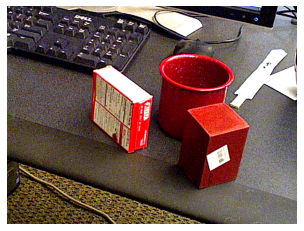

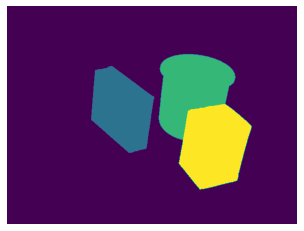

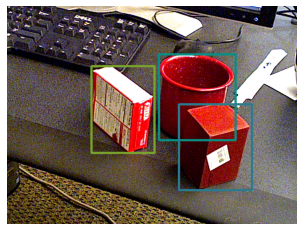

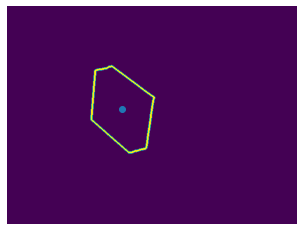

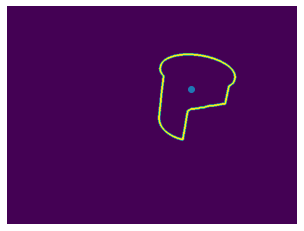

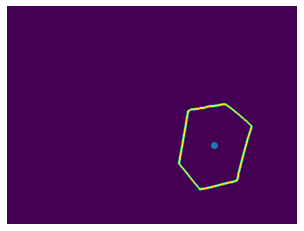

augmentated image


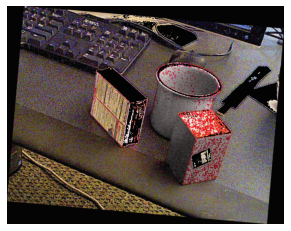

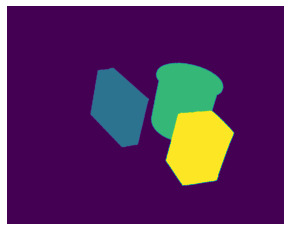

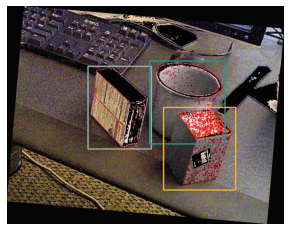

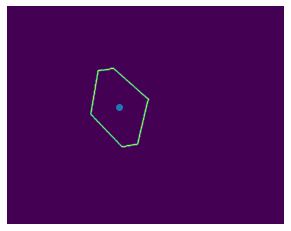

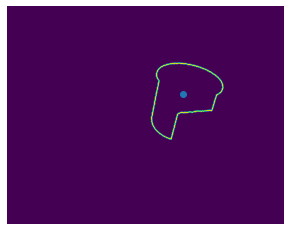

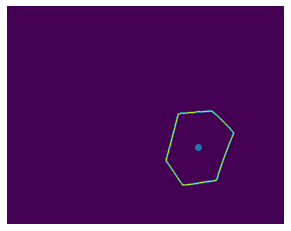

angle: -5 	scale: 1.5335673149312719 	s_val: 14 	v_val: 5
bbox =
 [[  0.         304.69024834 542.57385157 226.09465156 536.47002114]
 [  1.         536.06471851 819.51295219 206.28884978 517.61853206]
 [  2.         588.58239834 859.80877899 380.22033363 690.48074231]]
ct =
 [[419 379]
 [659 330]
 [719 529]]


In [ ]:
out_rgb, out_mask, bbox, ct = Augmentation(rgb, mask, rot_rng=[-10,10], scl_rng=[-2,2], s_rng=[-30, 30], v_rng=[-30, 30])

# 3. Depth Image to Pointcloud
- Depth Image 파일은 int16 or int32 로 읽어와야 함 
- 이후, factor_depth 로 나누면 Depth Image 의 pixel 마다 z축으로 meter 단위인 값이 나옴

In [ ]:
depth_path = '/content/drive/MyDrive/Test/000001-depth.png'
meta_path = '/content/drive/MyDrive/Test/000001-meta.mat'

In [ ]:
# Road camera intrinsic matrix and factor_depth from meta data
from scipy import io
f = io.loadmat(meta_path)

intrinsic_matrix = f['intrinsic_matrix']
factor_depth = f['factor_depth']

# Read depth image
depth = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE) # unit8
depth = np.int32(depth) # int32     # depth = depth.astype(np.int32)

In [ ]:
# print('Depth')
# plot(depth)

# print('intrinsic_matrix = \n', intrinsic_matrix)
# print("factor_depth =", factor_depth[0][0])

In [ ]:
def plot3D(XYZ, elev=-80, azim=-90):
  x = XYZ[:, 0]
  y = XYZ[:, 1]
  z = XYZ[:, 2]

  fig = plt.figure(figsize=(12.8, 9.6))
  ax = fig.add_subplot(111, projection='3d')
  ax.view_init(elev,azim)
  ax.scatter(x, y, z, s=1, alpha=0.6)

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.show()

In [ ]:
def depth_to_pointcloud(depth, K, scale):
  h, w = depth.shape
  fx = K[0][0]
  fy = K[1][1]
  cx = K[0][2]
  cy = K[1][2]

  u = np.arange(w)
  v = np.arange(h)
  u, v = np.meshgrid(u, v)

  u = np.int32(u)
  v = np.int32(v)

  Z = depth / scale
  X = (u - cx) * Z / fx
  Y = (v - cy) * Z / fy

  X = np.ravel(X)
  Y = np.ravel(Y)
  Z = np.ravel(Z)

  valid = Z > 0

  X = X[valid]
  Y = Y[valid]
  Z = Z[valid]

  # [N, 3]: X Y Z
  XYZ = np.stack((X, Y, Z), axis = 1)

  return XYZ

In [ ]:
XYZ = depth_to_pointcloud(depth, intrinsic_matrix, factor_depth)

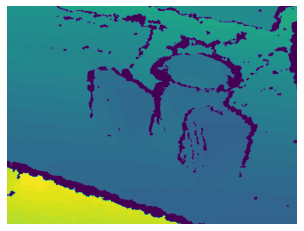

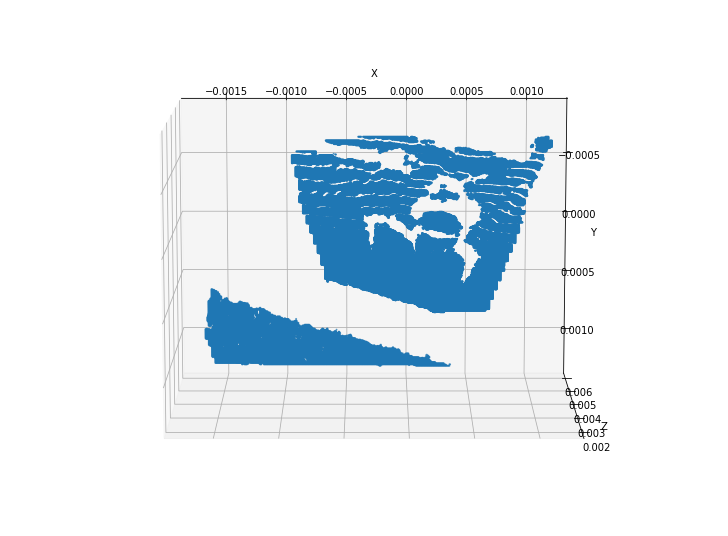

In [ ]:
plot(depth)
plot3D(XYZ)